# Earthquake Occurrence Statistics

The statistics of earthquake occurrence is revealed from catalogs of seismicity, which include event time, location and magnitude. We will talk about how earthquakes are located and how magnitudes are estimated separately, but for now it is sufficient to know that this information can be easily acquired. With such catalogs it is possible to compare the seismic activity of different regions, make informed assessments about the frequency of earthquake occurrence, and learn about the fault rupture process. Maps of the earthquakes in catalogs over time reveal the structure of faulting in a region, and provide a framework with which to study the seismotectonics of a region.

There are two primary earthquake statistics used by seismologists. They are the Gutenberg-Richter relationship (Gutenberg and Richter, 1949), and the Omori Law (Omori, 1894). 

Gutenberg and Richter found that when the logarithm of the number of earthquakes is plotted vs. magnitude that the distribution (data) may be described by the line (model), log(N)=A+Bm, where N is the number of earthquakes, m is the magnitude and A (y-intercept) and B (slope) are refered to as the Gutenberg-Richter statistics or coefficients. They found that on a global scale, and subsequently more generally, the B-value or the slope of the Gutenberg-Richter line is approximately equal to -1. Thus for each increase in earthquake magnitude there are approximately 10 times fewer earthquakes. If, for example, there are 100 M3 events in a region per year, then the Gutenberg-Richter relationship generally finds that there would be approximately 10 M4 events and 1 M5 event in each year. For magnitudes larger than M5 there would be fewer than one event per year. Gutenberg-Richter is a very important earthquake statistic because it is used to determine the rates of earthquake occurrence, which is a key step in characterizing earthquake hazards (we will see this in future homework exercises). 

The Omori Law is used to characterize the rate at which aftershocks occur following a large mainshock event. This statistic is used for comparing the aftershock productivity of different earthquakes and regions, make forecasts of the likelihood of large damaging aftershocks and to distinguish between earthquake faulting and possibly geothermal or volcanic-related seismicity by examining whether the distribution describes a "mainshock/aftershock" pattern or is more "swarm-like". 

In this homework you will use python code in this notebook to investigate the Gutenberg-Richter and Omori statistics for the San Francisco Bay Area, as well as develop numerical analysis skills using python. 

Note: This is not a python class, but the primary programming tool that will be used is python. However, if you know MatLab or have other programing background and would prefer to use it, you are free to use those tools instead. It will be helpful to read sections 9.6 and 9.8 of Lay and Wallace (1995) prior to working on this laboratory for background on the Gutenberg-Richter relation and the Omori Law.

In [1]:
#Initial Setup and Subroutine Definitions
!pip install cartopy -q
import math
import datetime
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two geographic points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    
    The first pair can be singular and the second an array

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371.0 * c
    return km

def countDays(c,y,m,d):
    '''
    Function to count days in the array
    '''
    days=np.zeros(c)
    for i in range(0,c,1):
        d0 = datetime.date(y[0], m[0], d[0])
        d1 = datetime.date(y[i], m[i], d[i])
        delta = d1 - d0
        days[i]=delta.days
    return days

def readAnssCatalog(p):
    '''
    Function to slice an ANSS catalog loaded as a pandas dataframe and return arrays of info, including days
    '''
    d=np.array(p)         # load the dataframe into numpy as an array      
    year=d[:,0].astype(int)  # define variables from the array
    month=d[:,1].astype(int)
    day=d[:,2].astype(int)
    hour=d[:,3].astype(int)
    minute=d[:,4].astype(int)
    sec=d[:,5].astype(int)
    lat=d[:,6]
    lon=d[:,7]
    mag=d[:,8]
    days = countDays(len(year),year,month,day)
    return year,month,day,hour,minute,sec,lat,lon,mag,days


### The Catalog
We have downloaded the Advanced National Seismic System (ANSS) catalog from 1900 to 2018 for you to use (also available here: http://www.quake.geo.berkeley.edu/anss/catalog-search.html), and saved it as a text-file named "anss_catalog_1900to2018all.txt". This catalog has all events in the aforementioned time range located within 100 km of UC Berkeley. Columns of this catalog include information about the catalogued earthquakes, including the date and time of each event, its location in latitude, longitude and depth, and the event magnitude.  

The following python code reads this catalog file and places the information in arrays for analysis.

In [2]:
#Read data and create data arrays

# This catalog is a M0+ search centered at Berkeley radius=100. 
# big enough to include Loma Prieta but exclude Geysers
data=pd.read_csv('anss_catalog_1900to2018all.txt', sep=' ', delimiter=None, header=None,
                names = ['Year','Month','Day','Hour','Min','Sec','Lat','Lon','Mag'])

year,month,day,hour,minute,sec,lat,lon,mag,days = readAnssCatalog(data)

In [3]:
data

,Year,Month,Day,Hour,Min,Sec,Lat,Lon,Mag
0,1911,7,1,22,0,0.00,37.2500,-121.7500,6.60
1,1932,6,14,9,44,17.00,37.2500,-122.0800,4.50
2,1932,6,30,0,23,0.00,37.5800,-122.0000,3.00
3,1932,7,12,4,33,41.00,37.6000,-121.8300,3.00
4,1933,5,16,11,45,26.00,37.6000,-122.0000,4.50
5,1934,4,23,16,8,0.00,37.0000,-122.0000,4.00
6,1934,10,2,20,20,0.00,37.6000,-122.8000,4.00
7,1934,10,2,20,30,0.00,37.6000,-122.8000,4.00
8,1936,9,24,14,11,0.00,37.6000,-122.8800,4.00
9,1937,3,8,10,31,0.00,37.8000,-122.2000,4.50


# Exercise 1: Explore the raw catalog (10 pts)

### Print the number of events, the number of days from the first event, the minimum magnitude, and the maximum magnitude

In [4]:
nevt=len(year)

from datetime import date

date0= date(year[0], month[0], day[0])
date1= date(year[nevt-1], month[nevt-1], day[nevt-1])

print('Number of events:' + ' ' + str(nevt))
print('Number of days from first event:' + ' ' + str((date1-date0).days))
print('Maximum magnitude:' + ' ' + str(max(mag)))
print('Minimum magnitude:' + ' ' + str(min(mag)))

Number of events: 69804
Number of days from first event: 38900
Maximum magnitude: 6.9
Minimum magnitude: 0.0


### Plot the catalog time series
Make an x-y plot showing the magnitude of the earthquake on the y-axis and the time of the event on the x-axis. For this it is useful to have already determined the days since the beginning of the catalog. The plot will show that the catalog is not uniform due to the fact that over time as more seismic recording stations were installed more earthquakes could be detected and properly located.

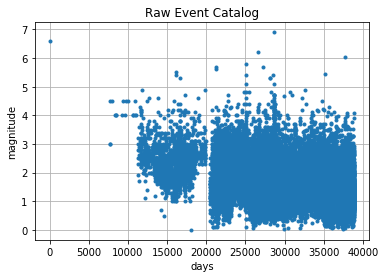

In [5]:
fig, ax = plt.subplots()
ax.plot(days, mag, '.') # ******
ax.set(xlabel='days', ylabel='magnitude',
       title='Raw Event Catalog')
ax.grid()
fig.savefig("hw1_ex1_fig1.png")
plt.show()

### Plot the catalog in map view
Familiarize yourself with the code example below as there will be additional exercises requiring the plotting of maps.

- Describe the seismicity and any patterns that you see.
- Try adding fault traces.
- How well does the seismicity show the region's major faults?

Answer:

- The areas with highest seismicity have higher concentrations of blue circles. These mainly occur along fault lines (despite several anomalies - could be aftershocks) and this plot needs declustering to make the major faults clearer but the San Andreas and Hayward faults can be seen more or less clearly. 

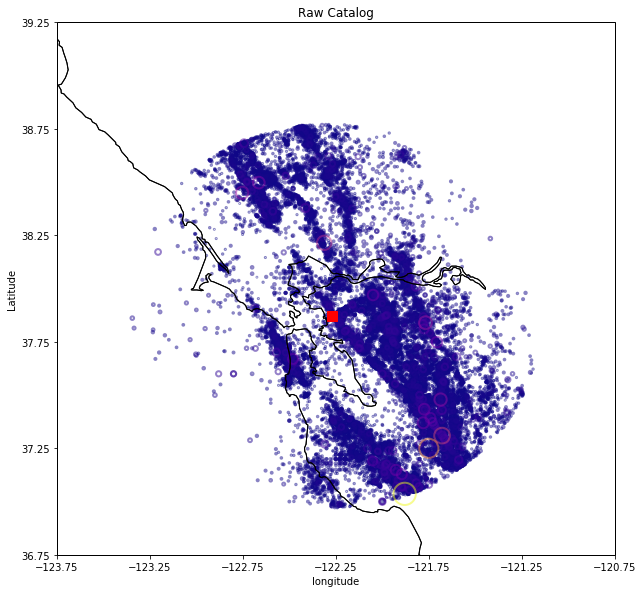

In [6]:
#Make a Map

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)
ydim=10      #height of plot
xdim=ydim*(haversine_np(lon0,lat0,lon1,lat0)/haversine_np(lon0,lat0,lon0,lat1)) #scale width

###
plt.figure(figsize=(ydim,xdim))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='longitude', ylabel='Latitude',
       title='Raw Catalog')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES,alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES.with_scale('10m'))

# Plot events as open circles with size and color proportional to event magnitude
indx=np.argsort(mag)   #determine sort index #Sort Descending to plot largest events on top
x=lon[indx]            #apply sort index
y=lat[indx]
z=np.exp(mag[indx])    #exponent to scale size
c = plt.cm.plasma(z/max(z))
plt.scatter(x ,y , s=z/2, facecolors='none', edgecolors=c, marker='o', linewidth=2, alpha=0.5) # *****

# Add Berkeley, CA as a red square with size proportional to event magnitude
plt.plot(-122.2727 ,37.8716 ,'rs',markersize=10) # *****

#Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('hw1_ex2_seismap_raw.pdf')
plt.savefig('hw1_ex2_seismap_raw.png')

plt.show()

# Exercise 2: Compute the Gutenberg-Richter statitistics (30 pts)

Follow the steps below to compute the Gutenberg Richter statistics for the raw catalog.

### Determine and plot the Gutenberg-Richter Distribution
First, define a range of magnitudes to bin the data. You can use a range of magnitude, m from 0.0 to 6.9 in increments of 0.1 magnitude unit. 


In [7]:
m=np.arange(0.0 , 6.9 , 0.1 ) # ***** define a range of mag bins with width 0.1 magnitude per bin
print(m)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8]


Next, count the number of events above a given magnitude. That is count the number of events above and equal to magnitude 0.0, then above and equal to 0.1, and so forth all the way to the maximum magnitude. You can do this by placing the code for vectorized counting of array elements passing a logical test (numpy.count_nonzero()) inside a for loop over the incremental magnitudes, m. We are interested in the annual rate of the events so you will need to divide by the total number of years the catalog spans. N is the log of of the number of events per year, so take the log base 10 (numpy.log10) of the annual number of earthquakes for each magnitude bin. Note you can place all of the operations in one line of code inside the for loop.

In [8]:
# Preallocate the vector N with a zeros vector of size len(m)
N= np.zeros(len(m))

# Find N
for i in range(0,len(m),1):
    N[i]= np.log10(np.count_nonzero(m[i] <= mag)/(days[-1]/365))
print(N)

# note that the final variable N should actually be log(N)

[ 2.81622357  2.81614891  2.81583766  2.81517708  2.81348365  2.81034181
  2.80200719  2.78909481  2.77202835  2.74350432  2.70452787  2.65439804
  2.59182269  2.53559884  2.46508969  2.40823539  2.33771892  2.25754039
  2.19333996  2.10849285  2.04175233  1.96165957  1.87905532  1.7809593
  1.69059576  1.61766726  1.52097832  1.421513    1.30619341  1.21810262
  1.1510325   1.03680125  0.939423    0.77374697  0.65987222  0.62939912
  0.52134653  0.42259237  0.29662572  0.22519629  0.21538131  0.00976976
 -0.0106234  -0.11917172 -0.21474338 -0.30338087 -0.49617782 -0.5091428
 -0.70543744 -0.70543744 -0.77238423 -0.82353675 -0.82353675 -0.91371338
 -0.91371338 -1.07341423 -1.1825587  -1.1825587  -1.42559675 -1.42559675
 -1.42559675 -1.55053548 -1.55053548 -1.72662674 -1.72662674 -1.72662674
 -2.02765674 -2.02765674 -2.02765674]


Make a plot of the distribution.

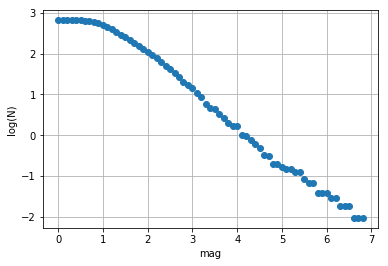

In [9]:
plt.figure()
plt.plot(m, (N) ,'o') # ******
plt.xlabel('mag')
plt.ylabel('log(N)')
plt.grid()

### Fit the data to find the Gutenberg Richter statistics.

Now, fit the data with the Gutenberg Richter relationship $log_{10}(N(m))$=A+Bm. In other words, "invert" the data to find the applied model parameters. We will walk through the steps of this inversion.

1) First, create the model parameter matrix, G, which has one column of 1's and a second column of magnitude bins, m.

$$
G=\begin{pmatrix}
1 &m_0\\
1 &m_1\\
1 &m_2\\
. &.\\
. &.\\
. &.\\
1 &m_n\\
\end{pmatrix}
$$

2) Next, create the data matrix, d, which in this case is a single column and contains the $log_{10}(N(m))$ values. Note that we already defined this vector above.

$$
d=\begin{pmatrix}
log_{10}(N(m_0))\\
log_{10}(N(m_1))\\
log_{10}(N(m_2))\\
.\\
.\\
.\\
log_{10}(N(m_n))\\
\end{pmatrix}
$$

In [10]:
tmp=np.ones(len(N))        # column of 1's
G=np.column_stack((tmp,m)) # matrix A

3) Next, compute the $G^{T}G$ matrix (G-transpose times G)  using numpy functions

In [11]:
GTG=np.dot(np.transpose(G),G)
GTG

array([[  69.  ,  234.6 ],
       [ 234.6 , 1071.34]])

4) Next, compute the $G^{T}D$ (A-transpose times D)

In [12]:
D = N # Recall that we have already defined the D-matrix above as "N"
GTD=np.dot(np.transpose(G),D)   # *****
GTD

array([ 46.1800333 , -64.28014639])

5) Finally, solve the inverse problem. Invert the equation $(G^{T}G)x=G^{T}D$ using the numpy linear algebra solver (numpy.linalg.solv()). The result, x, will be a vector of the Gutenberg-Richter coefficients, in which the A-value is x[0] and the B-value is x[1]. The values you should get are A=3.418 and B=-0.809.

In [13]:
# solve the linear inverse problem
soln=np.linalg.solve(GTG, GTD ) # ******
print(f'A-value={soln[0]:.3f}, B-value={soln[1]:.3f}')

A-value=3.418, B-value=-0.809


The linear Gutenberg-Richter model is fully defined by the A and B coefficients, however in order to plot a line through the distribution we need to take the dot product of G with our two-parameter solution vector.

In [14]:
x=m # the independent variable of the best-fit line is the same as for the data (magnitude bin)
y=np.dot(G,soln) # synthetic data

The resulting vector, "y", is called the synthetic data because it is a synthetic estimate of the real data. The difference between synthetic data and real data can be quantified through uncertainty analysis

### Uncertainty analysis of Gutenberg-Richter model

Next, compute the uncertainties of the model (best-fit line defined by the A and B coefficients). 

The following steps outline how to compute 95% confidence intervals for the model using the numpy and scipy packages in Python.

1) df=(length_of_data) - (number_of_model_parameters) #degree of freedom

2) e=data-(model predictions) #prediction error

3) variance=np.sum(e*e)/df

4) se_y=np.sqrt(var)                       #standard error of the estimate

5) sdev=np.sqrt(var)                       #standard deviation

6) t=stats.t.ppf(1-0.05/2,degfree)             #two-sided students t-distribution

7) lower95=np.exp(np.log(modeled_pga)-t*se_y)

8) upper95=np.exp(np.log(modeled_pga)+t*se_y) 

9) se_b=sdev/np.sqrt(np.sum((x-np.mean(x))**2)) # standard error of slope

10) se_a=sdev*np.sqrt(1/len(x) + np.mean(x)**2/np.sum((x-np.mean(x))**2)) # standard error of intercept (9 and 10 will be important for incorporating Gutenberg Richter uncertainty in PSHA (a future homework)

In [15]:
#Compute the uncertainty in Gutenberg-Richter Parameters

length_of_data = len(N)
number_of_model_parameters = 2
df=(length_of_data) - (number_of_model_parameters) #degree of freedom

e=N-y #prediction error

var=np.sum(e*e)/df

se_y=np.sqrt(var)             #standard error of the estimate
sdev=np.sqrt(var)             #standard deviation

#Calculate 95% confidence bounds
t=stats.t.ppf(1-0.05/2,df)    #two-sided students t-distribution
tmp=np.sqrt(1/len(x)+((x-np.mean(x))**2)/np.sum((x-np.mean(x))**2))
tmp=tmp/max(tmp)
lower95=y-t*se_y*tmp
upper95=y+t*se_y*tmp
se_b=sdev/np.sqrt(np.sum((x-np.mean(x))**2))                      #standard error slope
se_a=sdev*np.sqrt(1/len(x) + np.mean(x)**2/np.sum((x-np.mean(x))**2)) #standard error of intercept
a95=se_a*t
b95=se_b*t

### Plot the fit to the data
To visualize the fit to the distribution, we would like to make a plot showing the magnitude distribution as plotted above, log10(N) vs m, with the best fit line that we just found the coefficients for. Visalize the uncertainty by plotting the upper and lower 95 percentiles of the data.

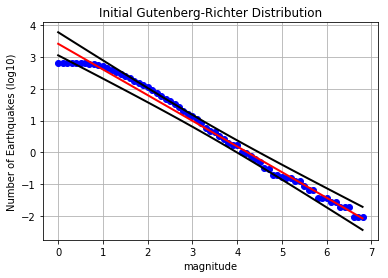

In [16]:
fig, ax = plt.subplots()

#plot the distribution like above
ax.plot(m,N,'bo')

#plot the best-fit line with uncertainties
ax.plot(x,y,'r-',linewidth=2)

# plot the 95% confidence intervals
ax.plot(x,upper95,'k-',linewidth=2) # *****
ax.plot(x,lower95,'k-',linewidth=2) # *****

ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Initial Gutenberg-Richter Distribution')
ax.grid()
plt.savefig("hw1_ex3_figure2_withErrorBounds.png")
plt.show()


## Questions

1. What do the Gutenberg Ricther statistics represent for the earthquake distribution?
2. What happens to the shape of the distribution (log(N)) if you reduce the magnitude bin size by a factor of 10?
3. Why does the model parameter matrix (G) have a column of 1's?
4. What determines the size of $G^TG$ and $G^Td$?
5. How well does the Gutenberg-Richter model fit the data? Quantify your answer in terms of uncertainty.
6. Where does the fit begin to breakdown and why?
7. Based on your Gutenberg-Richter coefficients what is the annual rates of a M4 earthquakes? For a M7 earthquake?
8. On average how many years are there between M7 earthquakes based on this catalog.
9. How many M7 earthquakes are in the catalog?
10. What is your assessment of the quality or suitability of the forecast of average M7 occurrence?

## Answers 

1. The statistics represent the relationship between the magnitude and the total number of earthquakes in a given region, with a time period equivalent to that of at least a specific magnitude. 
2. The shape of the distribution does not change. All that occurs is that we are provided with more data points. This reduces the uncertainty in our results. 
3. This is to satisfy the rules of matrix multiplication. The number of columns of $G$ needs to equal 2 so that the matrix multiplicaiton $G^Td$ results in a 2x1 vector quantity. For the left hand side of the equation to also be satisfied, $G^TG$ needs to be a 2x2 matrix, so 2 columns are required to be in $G$.
4. The sizes of $G^TG$ and $G^Td$ are independent of the number of data as a result of the rules of matrix multplication. $G$ is always nx2 and $d$ is always nx1 (where n is the number of data). Consequently, $G^Td$ is always (2xn)(nx1)= (2x1) and $G^TG$ is always (2xn)(nx2) = (2x2). 
5. The model fits the data generally well, with an uncertainty that is equal to the standard deviation (square-root of the variance), which comes out to about 1.82% (see calculation below).
6. It begins to break down at magnitudes less than one. This is likely due to the fact that it is difficult to measure seismic activity of such a small magnitude accurately. This is because of interference from sources like sound. Consequently, the number of earthquakes recorded at such magnitudes may not fit the data. Also, the data may not fit well for magnitudes greater than or equal to 7, since the original set of data did not have data for events that had magnitude greater than 6.9.
7. Annual rate of M4 earthquakes is approximately 2 (rounded to the nearest integer), annual rate of M7 earthquakes is around 0.0057 (rounded to 4 decimal places). [see calculation below]
8. Since the annual rate of magnitude 7 earthquakes is around 0.57%, we should expect an average of one magnitude 7 earthquake every 176 years. 
9. There are no M7 earthquakes in the catalog. (see calculation below) 
10. Also, the chances of a M7 event occuring in a year (~0.57%) is less than the margin of error (~1.8%), so we cannot really rely on this model for events that have a smaller probability of occurring. We know that the 1989 Loma Prieta earthquake had a magnitude of 6.9 and the 1906 San Francisco earthquake had a magnitude of 7.9. Both earthquakes occurred on different points of the San Andreas fault in an 83 year interval. Consequently, the forecast we have is not really reliable because it does not take into account the fact that different points on the fault are moving in different relative directions. As a result, the average M7 occurrence may not always follow the forecast. This was seen during the Parkfield experiment, which factored in previous occurences into its forecast. However, the forecast is useful in that it lets people know how long overdue a certain fault area is to earthquakes and will thus keep people cautious on the mitigating and adapting to the dangers of earthquakes, thus increasing preparedness. 

In [17]:
print('Number of M7 earthquakes in catalog: ' + str(np.count_nonzero(mag==7)))
print('Annual rate of M4 earthquakes: ' + str((10**(soln[0]+soln[1]*4))))
print('Annual rate of M7 earthquakes: ' + str((10**(soln[0]+soln[1]*7))))
print('Uncertainty in N: ' + str(sdev))
print('Standard error of slope: ' + str(se_b))
print('Standard error of intercept: ' + str(se_a))

Number of M7 earthquakes in catalog: 0
Annual rate of M4 earthquakes: 1.5281398783487599
Annual rate of M7 earthquakes: 0.005735871729098461
Uncertainty in N: 0.18204538627361022
Standard error of slope: 0.011003789605884244
Standard error of intercept: 0.04335921319038039


# Exercise 3: Declustering (30 pts)

In the above analysis mainshocks (primary events) and aftershocks are mixed together. The results for the Gutenberg-Richter statistics were generally pretty good, however a correct implementation of Gutenberg-Richter considers only the primary events. Therefore, we seek a catalog with aftershocks removed in order to improve our assessment of the Gutenberg-Richter statistics. The process to remove aftershocks is called declustering.

In this exercise, you will evaluate a published declustering method as you use it to decluster the catalog analyzed above. Then you will re-compute the Gutenberg-Richter coefficients for the declustered catalog in order to examine the affect on the G-R statistics.

### Declustering Algorithm

The analysis that was just performed was for the raw catalog, which means that it includes all events. However Gutenberg-Richter is really interested in the occurrence of primary "main shock" events, and therefore it is necessary to decluster the catalog to obtain an unbiased estimate of the G-N coefficients. Declustering here means remove the aftershocks from the catalog. This is done using an algorithm that relates the "expected" time and distance range of aftershocks from a given mainshock. Large mainshocks will result in aftershock populations that, statistically speaking, have a greater likelihood to occur over longer time periods and greater mainshock-aftershock distances compared with smaller mainshock-aftershock series. 

The code block below defines a declustering algorithm. This algorithm uses distance and time metrics that are magnitude dependent, called 'Dtest' and 'Ttest'. If a given event falls within the maximal values defined by Dtest and Ttest for its magnitude it is deemed an aftershock and removed from the catalog. After all events are processed, the remaining catalog is then comprised of only primary events. This declustered catalog can be used to estimate more accurate Gutenberg-Richter statistics. Furthermore, we can study the aftershock events that the algorithm removed for a given earthquake in the context of the Omori Law statistics (Exercise 4).

Because aftershock identification is an empirical procedure, there are many different ways to define the Dtest and Ttest relationships. Stiphout et al., (2012, on page 10) summarizes three different definitions of the Dtest/Ttest relationships originally proposed by Uhrhammer (1986), Knopoff and Gardner (1972), and Gruenthal. 

Compare the event reduction rate (final number divided by the initial number of events) for the three different proposed distance and time windows. You can do this by adding a logical (if statement) tree to enable switching between different definitions of Dtest and Ttest in declustering_algorithm below. The first definition (Eqn 1 from Stiphout et al., 2012, p.10) has already been completed.

In [18]:
def declustering_algorithm(cat,definition=1):
    '''
    Decluster a catalog
    
    note: This function may take a few minutes to complete
    
    calls readAnssCatalog()
    
    Inputs: 
    
    cat must be an anss formatted pandas datafram
    definition is the algorithm (1 - 3) from Stiphout, 2012, which determines Dtest and Ttest values
        Definition = 1 : Gardner and Knopoff, 1974 [default]
        Definition = 2 : Gruenthal
        Definition = 3 : Uhrhammer, 1986
    
    '''
    import numpy as np
    
    # do not edit
    cnt=0
    save=np.zeros((1,10000000),dtype=int)

    # grab catalog arrays
    year,month,day,hour,minute,sec,lat,lon,mag,days = readAnssCatalog(cat)
    ne=len(year)

    # main for-loop over events
    for i in range(0,ne,1):
        
        if definition == 1:
            # Definition #1 : Knopoff and Gardner, 1972
            Dtest=np.power(10,0.1238*mag[i]+0.983)
            if mag[i] >= 6.5:
                Ttest=np.power(10,0.032*mag[i]+2.7389)
            else:
                Ttest=np.power(10,0.5409*mag[i]-0.547)

        elif definition == 2:
            # Definition #2 : Gruenthal # *****
            Dtest=np.exp(1.77+(0.037+1.02*mag[i])**2)  # distance bounds
            if mag[i] >= 6.5:
                Ttest=abs(np.exp(-3.95+(0.62+17.32*mag[i])**2)) # aftershock time bounds for M >= 6.5
            else:
                Ttest=np.power(10,0.024*mag[i]+2.8)  # aftershock time bounds for M < 6.5
    
        elif definition == 3:
            # Definition #3 # *****
            Dtest=np.exp(-1.024+0.804*mag[i])
            Ttest=np.exp(-2.87+1.235*mag[i])

            
            
        a=days[i+1:ne]-days[i]
        m=mag[i+1:ne]
        b=haversine_np(lon[i],lat[i],lon[i+1:ne],lat[i+1:ne])

        icnt=np.count_nonzero(a <= Ttest)
        if icnt > 0:
            itime=np.array(np.nonzero(a <= Ttest)) + (i+1)
            for j in range(0,icnt,1):             
                if b[j] <= Dtest and m[j] < mag[i]:
                    save[0][cnt]=itime[0][j]
                    cnt += 1 # save contains index of aftershocks in cat

    #Note this is an array of indexes that will be used to delete events flagged 
                        #as aftershocks
    save=np.delete(np.unique(save),0)  
    
    # Filter or slice out the declustered and aftershock dataframe catalogs from the 
    # original dataframe catalog "data" using "save" above.
    cat_aftershocks = cat.iloc[np.unique(save)] # *****
    cat_declustered = cat.iloc[~cat.index.isin(save)]
    
    cat_aftershocks.reset_index(drop=True, inplace=True)
    cat_declustered.reset_index(drop=True, inplace=True)
    
    return cat_declustered, cat_aftershocks

In [19]:
# Run the declustering algorithm
data_declustered, data_aftershocks = declustering_algorithm(data,definition=1)

# This condition should print out "True" if the catalogs were separated correctly
len(data) == len(data_aftershocks) + len(data_declustered)

True

### Plot a map showing the declustered catalog 

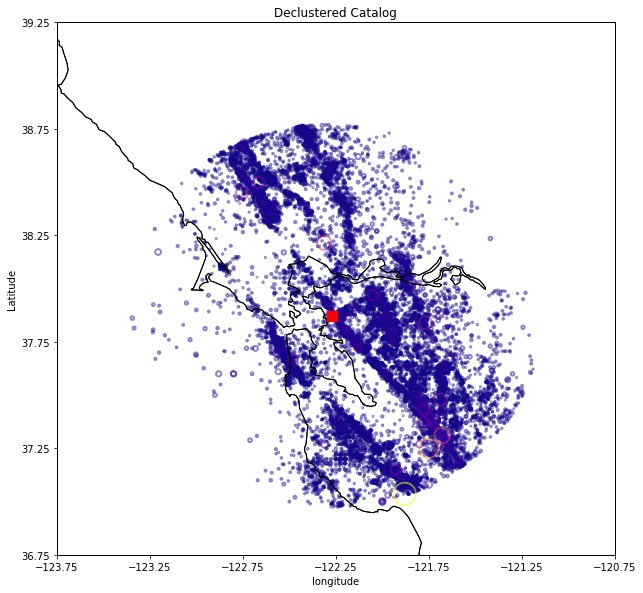

In [20]:
# load the declustered dataframe into numpy as an array with different d"" variable names  
dyear,dmonth,dday,dhour,dmn,dsec,dlat,dlon,dmag,ddays = readAnssCatalog(data_declustered)

#Make map
lat0=36.75 #Set Corners of Map
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)
ydim=10      #height of plot
xdim=ydim*(haversine_np(lon0,lat0,lon1,lat0)/haversine_np(lon0,lat0,lon0,lat1)) #scale width
plt.figure(figsize=(ydim,xdim))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='longitude', ylabel='Latitude',
       title='Declustered Catalog')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES,alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES.with_scale('10m'))

# Plot events as open circles with size and color proportional to event magnitude
indx=np.argsort(dmag)   #determine sort index #Sort Descending to plot largest events on top
x=dlon[indx]            #apply sort index
y=dlat[indx]
z=np.exp(dmag[indx])    #exponent to scale size
c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors='none', edgecolors=c, marker='o', linewidth=2, alpha=0.5) # *****

# Add Berkeley, CA as a red square with size proportional to event magnitude
plt.plot(-122.2727,37.8716,'rs',markersize=10) # *****

#Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('hw1_ex4_seismap_declust.pdf')
plt.savefig('hw1_ex4_seismap_declust.png')

plt.show() 

### Re-compute the Gutenberg-Richter statistics as above for the declustered catalog

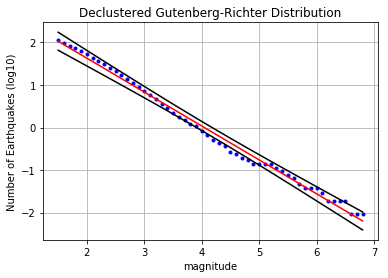

A_value= 3.221 B_value=-0.797
95%intercept= 0.082 95%slope=0.018


In [21]:
#Determine and plot the Gutenberg-Richter Distribution for De-clustered data
#You may want to adjust the magnitude range of the analysis to focus on where the catalog is complete
m=np.arange(1.5,6.9,0.1)
N=np.zeros(len(m))

for i in range(0,len(m),1):
    N[i]=np.log10(np.count_nonzero(dmag >= m[i])/(days[-1]/365))

#Invert for A and B values
tmp=np.ones(len(N))
G=np.column_stack((tmp ,m)) # *****
GTG=np.dot(np.transpose(G),G)
GTD=np.dot(np.transpose(G),N)
soln=np.linalg.solve(GTG,GTD) # *****
x=m
y=np.dot(G,soln) # *****

#Compute the uncertainty in Gutenberg-Richter Parameters
df=len(N) - 2                 #degree of freedom
e=N-y                         #prediction error
var=np.sum(e**2)/df
se_y=np.sqrt(var)             #standard error of the estimate
sdev=np.sqrt(var)             #standard deviation

#Calculate 95% confidence bounds
t=stats.t.ppf(1-0.05/2,df)    #two-sided students t-distribution
tmp=np.sqrt(1/len(x)+((x-np.mean(x))**2)/np.sum((x-np.mean(x))**2))
tmp=tmp/max(tmp)
lower95=y-t*se_y*tmp
upper95=y+t*se_y*tmp
se_b=sdev/np.sqrt(np.sum((x-np.mean(x))**2))                      #standard error slope
se_a=sdev*np.sqrt(1/len(x) + np.mean(x)**2/np.sum((x-np.mean(x))**2)) #standard error of intercept
a95=se_a*t
b95=se_b*t

#Now Plot
fig, ax = plt.subplots()
ax.plot(m, N,'b.',x,y,'r-',x,lower95,'k-',x,upper95,'k-')
ax.set(xlabel='magnitude', ylabel='Number of Earthquakes (log10)',
       title='Declustered Gutenberg-Richter Distribution')
ax.grid()

fig.savefig("hw1_ex4_figure4.png")
plt.show()

print(f'A_value= {soln[0]:.3f} B_value={soln[1]:.3f}')
print(f'95%intercept= {a95:.3f} 95%slope={b95:.3f}')

### Questions

1. How many events were removed from the catalog by each declustering algorithm?

2. Compare the spatial distribution of earthquakes between the raw and declustered catalogs.

3. For the two other methods of declusting, how many events were removed from the catalog?

4. Compare the Gutenberg-Richter A and B coefficients for the three versions of the declustered catalog.

5. What is the annual rate of occurrence of M4 earthquakes for each of the declustered catalogs?

6. What is the average M7 return period (inverse of annual occurrence of M7 events) for each of the declustered catalogs?

7. Compare your estimated values with what has been presented in the USGS Earthquake Hazard Assessments of the return period for Hayward fault earthquakes.

### Answers

1. 45563 events were removed by using definition 1, 21757 by using definition 3. Definition 2's code has an issue and thus I was not able to run it properly. 
2. On the declustered catalog, majority of the earthquakes are concentrated closer to major fault lines (the San Andreas and Hawyard faults can be seen most clearly). This is due to the fact that most aftershock event take place further away from the fault.  
3. 21757 by definition 3, and definition 2 did not run. You can check this by checking len(data_aftershocks). 
4. The absolute value of the A and B values increased between definition 1 and 3 (see actual numbers below). Definition 2 did not run. 
5. Using definition 3, annual rate of M4 earthquakes is 1.26. Using definition 1, annual rate of M4 earthquakes is 1.08. 
6. Average return period using definition 3 is 256 years. Average return period using defintion 1 is 226 years. 
7. According to USGS, it takes about 140 years for the Hayward fault to accumulate enough energy to produce a major earthquake. We estimated 256 years, which is 1.8 times longer than USGS's estimation. Either there is some issue with my code, or our declustering algorithim is not effective enough. 

In [22]:
print('Events removed from catalog by declustering algorithim 1: 45563')
print('A-value, B-value by definition 1: 3.221, -0.797')
print('Events removed from catalog by declustering algorithim 2: N/A since definition 2 does not run properly' )
print('A-value, B-value by definition 2: N/A since definition 2 does not run properly ' )
print('Events removed from catalog by declustering algorithim 3: 21757')
print('A-value, B-value by definition 3: 3.448, -0.836')
print('Annual rate of M4 earthquakes using definition 1: 1.084930990419052') #10**(soln[0]+soln[1]*4)
print('Annual rate of M4 earthquakes using definition 3: 1.2647367046899372' ) #10**(soln[0]+soln[1]*4)
print('Return period of M7 earthquakes using definition 1: 226.01193385961648') #1/(10**(soln[0]+soln[1]*7))
print('Return period of M7 earthquakes using definition 3: 255.51331715667368') #1/(10**(soln[0]+soln[1]*7))

Events removed from catalog by declustering algorithim 1: 45563
A-value, B-value by definition 1: 3.221, -0.797
Events removed from catalog by declustering algorithim 2: N/A since definition 2 does not run properly
A-value, B-value by definition 2: N/A since definition 2 does not run properly 
Events removed from catalog by declustering algorithim 3: 21757
A-value, B-value by definition 3: 3.448, -0.836
Annual rate of M4 earthquakes using definition 1: 1.084930990419052
Annual rate of M4 earthquakes using definition 3: 1.2647367046899372
Return period of M7 earthquakes using definition 1: 226.01193385961648
Return period of M7 earthquakes using definition 3: 255.51331715667368


# Exercise 4: Omori Law for Loma Prieta M6.9 Event (30 pts)

Here we will use the declustering algorithm to identify aftershocks of the October 18 1989 at 04:15am (October 17 at 5:15pm PDT) the M6.9 Loma Prieta earthquake occurred in the Santa Cruz mountains approximately 80 km southwest of the Berkeley Campus. This wiki has some background information for the earthquake: https://en.wikipedia.org/wiki/1989_Loma_Prieta_earthquake

### Load the Earthquake Catalog

Load the .csv data file of all the earthquakes 1900 - 2018 in the ANSS (Advanced National Seismic System) catalog from 100 km around Berkeley.

In [23]:
# This catalog is a M0+ search centered at Berkeley radius=100km. 
# A big enough radius to include Loma Prieta but exclude Geysers.
data=pd.read_csv('anss_catalog_1900to2018all.txt', sep=' ', delimiter=None, header=None,
                 names = ['Year','Month','Day','Hour','Min','Sec','Lat','Lon','Mag'])
year,month,day,hour,minute,sec,lat,lon,mag,days = readAnssCatalog(data)

data

,Year,Month,Day,Hour,Min,Sec,Lat,Lon,Mag
0,1911,7,1,22,0,0.00,37.2500,-121.7500,6.60
1,1932,6,14,9,44,17.00,37.2500,-122.0800,4.50
2,1932,6,30,0,23,0.00,37.5800,-122.0000,3.00
3,1932,7,12,4,33,41.00,37.6000,-121.8300,3.00
4,1933,5,16,11,45,26.00,37.6000,-122.0000,4.50
5,1934,4,23,16,8,0.00,37.0000,-122.0000,4.00
6,1934,10,2,20,20,0.00,37.6000,-122.8000,4.00
7,1934,10,2,20,30,0.00,37.6000,-122.8000,4.00
8,1936,9,24,14,11,0.00,37.6000,-122.8800,4.00
9,1937,3,8,10,31,0.00,37.8000,-122.2000,4.50


### Select earthquakes related to the Loma Prieta Earthquake

Use Boolean indexing to select events from the full catalog from between October 18, 1989 (date of mainshock) and December 18, 1989 (3-months following).

In [24]:
EQ_1989 = data[(data.Year>=1989) & (data.Year<1990)]  # *****        #get one year of data

fall_eq = EQ_1989[(EQ_1989.Month>9) & (EQ_1989.Month<=12)]    #collect months of Oct, Nov and Dec
LP_eq = fall_eq[(~((fall_eq.Month==10) & (fall_eq.Day<18)))]  #negate events before day (assumes first month is 10)
LP_eq = LP_eq[(~((LP_eq.Month==12) & (LP_eq.Day>18)))]        #negate events after day (assumes last month is 12)
LP_eq.reset_index(drop=True, inplace=True)

LP_eq

,Year,Month,Day,Hour,Min,Sec,Lat,Lon,Mag
0,1989,10,18,0,4,15.19,37.0362,-121.8798,6.90
1,1989,10,18,0,7,15.29,37.2382,-121.9445,4.70
2,1989,10,18,0,8,21.99,37.0702,-121.8940,4.40
3,1989,10,18,0,8,45.47,37.0760,-121.9250,4.30
4,1989,10,18,0,9,29.53,37.1577,-121.9610,3.41
5,1989,10,18,0,11,45.39,37.1662,-121.9860,4.20
6,1989,10,18,0,12,42.30,37.1760,-121.9782,4.60
7,1989,10,18,0,13,8.67,37.1748,-122.0335,4.32
8,1989,10,18,0,15,48.78,37.1613,-122.0005,2.55
9,1989,10,18,0,16,14.52,37.1835,-121.9632,3.26


Create data arrays for 3-month period beginning with Loma Prieta Earthquake

In [25]:
# year,month,day,hour,minute,sec,lat,lon,mag = readAnssCatalog(EQ_1989)#override for plotting entire year catalog
year,month,day,hour,minute,sec,lat,lon,mag,days = readAnssCatalog(LP_eq)
nevt = len(mag)

### Plot the Loma Preita time series

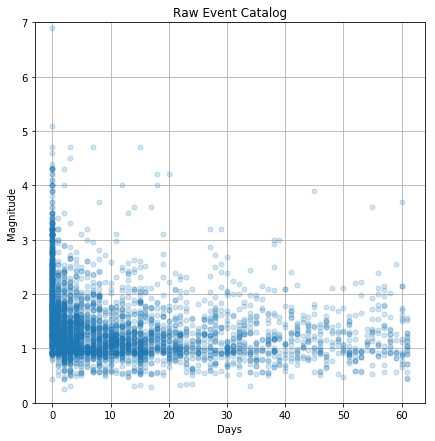

Number=3692 MinMag=0.25 MaxMag=6.90


In [26]:
# plot magnitude vs. day
fig, ax = plt.subplots(figsize=(7,7))
ax.plot( days , mag ,'o',alpha=0.2,markersize=5) # *****
ax.set(xlabel='Days', ylabel='Magnitude',
       title='Raw Event Catalog')
ax.grid()
ax.set_ylim([0,7])
fig.savefig("hw1_ex4_ts_raw.png")
plt.show()

print(f'Number={nevt:d} MinMag={min(mag):.2f} MaxMag={max(mag):.2f}')

### Plot the Loma Preita Earthquake Catalog in map view

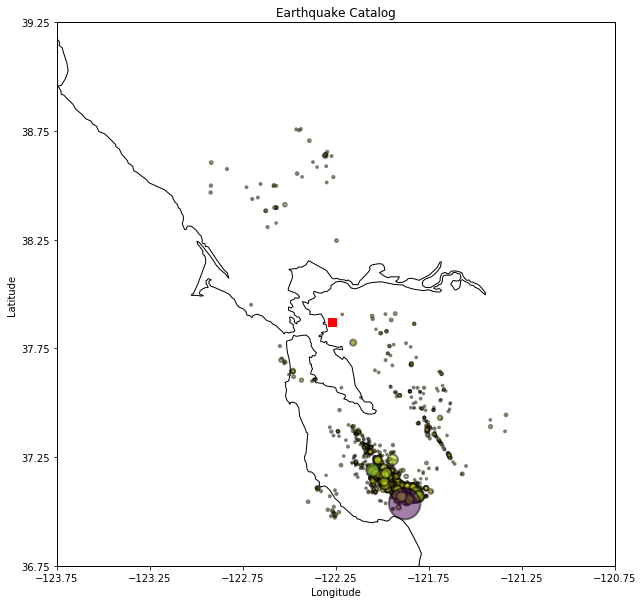

In [27]:
#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1)
ax.set_aspect('auto')
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Earthquake Catalog')

#Sort Descending to plot largest events on top
indx=np.argsort(mag)   #determine sort index
x=lon[indx]            #apply sort index
y=lat[indx]
z=np.exp(mag[indx])    #exponent to scale size
c = plt.cm.viridis_r(z/max(z)) # colormap scales with magnitude
plt.scatter(x, y, s=(z), facecolors=c, alpha=0.5, edgecolors='k', marker='o', linewidth=2) # plot circles on EQs
plt.plot(-122.2727,37.8716,'rs',markersize=8)  # plot red square on Berkeley

plt.savefig("hw1_ex4_map_raw.png")

plt.show()

### Decluster the Raw Catalog for the Loma Prieta time period

We use the same decluster algorithm previously to identify aftershocks and remove them from the 30-day Loma Preita catalog.

In [28]:
data_dec, data_after = declustering_algorithm(LP_eq,definition=1)

# This condition should print out "True" if the catalogs were separated correctly
len(LP_eq) == len(data_after) + len(data_dec)

True

Create two sets of arrays, one for the declustered catalog and one for the aftershock catalog. Use `np.delete()` to delete the aftershock events for the declustered catalog, and use `after` to select the aftershock events for the aftershock calalog. 

In [29]:
dyear,dmonth,dday,dhour,dminute,dsec,dlat,dlon,dmag,ddays = readAnssCatalog(data_dec)
ayear,amonth,aday,ahour,aminute,asec,alat,alon,amag,adays = readAnssCatalog(data_after)
dnevt =len(ddays)
anevt=len(adays)

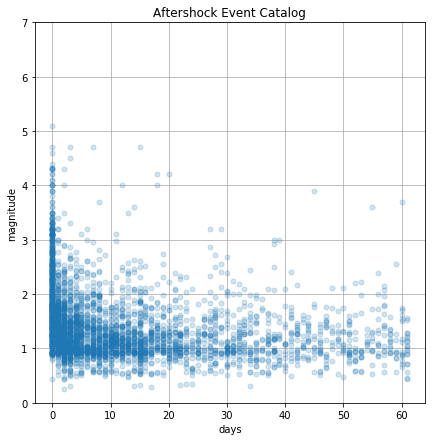

Number=3641 MinMag=0.25 MaxMag=5.10


In [31]:
#Plot Aftershock Catalog in time series
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(adays ,amag  ,'o',alpha=0.2,markersize=5)
ax.set(xlabel='days', ylabel='magnitude',
       title='Aftershock Event Catalog')
ax.grid()
ax.set_ylim([0,7])
fig.savefig("hw1_ex4_ts_aftershockOnly.png")
plt.show()

print(f'Number={anevt:d} MinMag={min(amag):.2f} MaxMag={max(amag):.2f}')

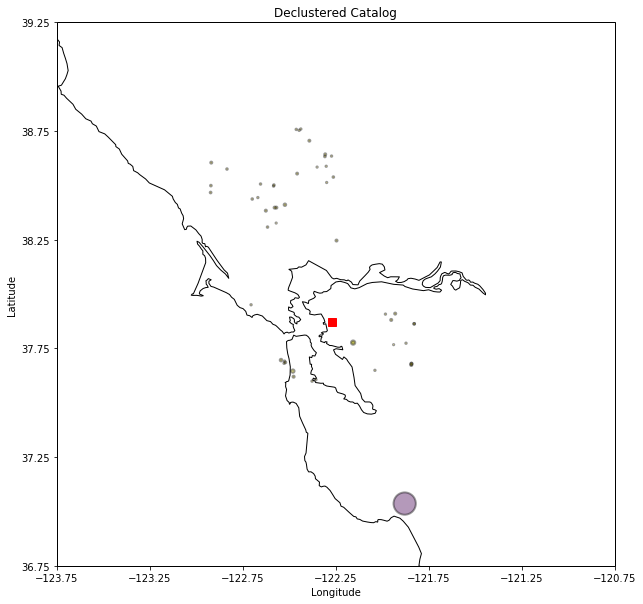

In [32]:
#Make a Map of the declustered events

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Declustered Catalog')

#Sort Descending to plot largest events on top
indx=np.argsort(dmag)   #determine sort index
x=dlon[indx]            #apply sort index
y=dlat[indx]
z=np.exp(dmag[indx])    #exponent to scale size
c = plt.cm.viridis_r(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors=c, alpha=0.4, edgecolors='k', marker='o', linewidth=2)
plt.plot(-122.2727,37.8716,'rs',markersize=8)

plt.savefig("hw1_ex4_map_mainshockOnly.png")


plt.show()

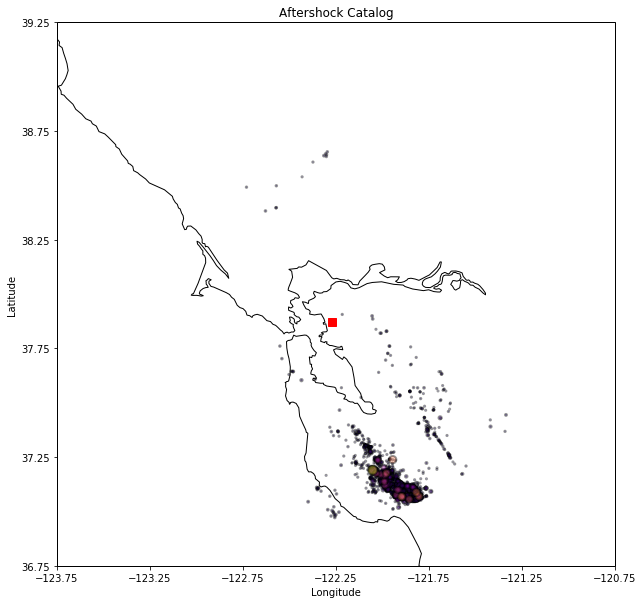

In [33]:
#Make a Map of Aftershock events

#Set Corners of Map
lat0=36.75
lat1=39.0
lon0=-123.75
lon1=-121.0
tickstep=0.5 #for axes
latticks=np.arange(lat0,lat1+tickstep,tickstep)
lonticks=np.arange(lon0,lon1+tickstep,tickstep)

plt.figure(1,(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.coastlines(resolution='10m',linewidth=1) #downloaded 10m, 50m
ax.set_xticks(lonticks)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set(xlabel='Longitude', ylabel='Latitude',
       title='Aftershock Catalog')

#Sort Descending to plot largest events on top
indx=np.argsort(amag)   #determine sort index
x=alon[indx]            #apply sort index
y=alat[indx]
z=np.exp(amag[indx])    #exponent to scale size
c = plt.cm.plasma(z/max(z))
plt.scatter(x, y, s=(z/2), facecolors=c, alpha=0.4, edgecolors='k', marker='o', linewidth=2)
plt.plot(-122.2727,37.8716,'rs',markersize=8)

plt.savefig("hw1_ex4_map_aftershockOnly.png")

plt.show()

### Omori statistics

To compute the Omori statistics we want to bin the log10 of the number of aftershocks each day following the mainshock and fit a power law equation such as:

\begin{matrix}
N=\frac{A}{(t+\epsilon)^P}, 
\end{matrix}

where t is time in days, N is the number of earthquakes in the 24 hour period, and $\epsilon$ is a small number (fraction of a day) to avoid the singularity at zero time. A and P are the coeffients that we want to find through regression. This power law equation can be linearized by simply taking the log10 of both sides giving:

\begin{matrix}
log_{10}(N)=a - P*log_{10}(t+\epsilon)
\end{matrix}

Note: We will use both the Gutenberg-Richter and the Omori Law statistics computed in Homework 1 in Homework 2 where we will examine the probability of earthquake occurrence and aftershock occurrence following a given mainshock.



In [74]:
#find the number of aftershocks in each day
epsilon=0.1
maxdays=np.int(np.max(adays))
t=np.arange(1,maxdays+2,1)
logt=np.log10(t)
N=np.zeros(maxdays+1)

for i in range(0,maxdays+1,1):
    N[i]=np.count_nonzero(adays == i)
logN=np.log10(N)

#Invert for A and B values
tmp=np.ones(len(logN))
G=np.column_stack((tmp,-logt))
GTG=np.dot(np.transpose(G),G ) # *****
GTD=np.dot(np.transpose(G) , logN) # *****
soln=np.linalg.solve(GTG,GTD) # ***** 
x=10**logt # *****
y=10**(np.dot(G,soln))# *****

print(f'A_value= {soln[0]:.3f} P_value={soln[1]:.3f}')

A_value= 2.961 P_value=1.062


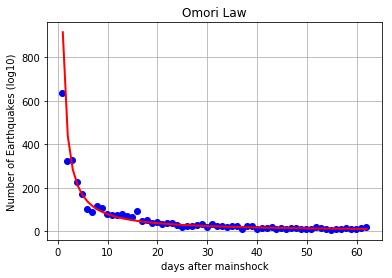

In [75]:
#Now Plot
fig, ax = plt.subplots()
ax.plot(t-epsilon, N,'bo',x,y,'r-',linewidth=2)
ax.set(xlabel='days after mainshock', ylabel='Number of Earthquakes (log10)',
       title='Omori Law')
ax.grid()
plt.savefig("hw1_ex4_OmoriStats_linlin.png")
plt.show()

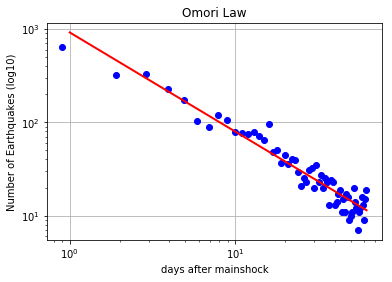

In [76]:
#Now Plot
fig, ax = plt.subplots()
ax.loglog(t-epsilon, N,'bo',x,y,'r-',linewidth=2)
ax.set(xlabel='days after mainshock', ylabel='Number of Earthquakes (log10)',
       title='Omori Law')
ax.grid()
plt.savefig("hw1_ex4_OmoriStats_loglog.png")
plt.show()

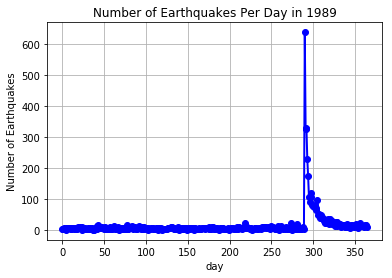

In [77]:
#plot of the number of earthquakes per day for 1989

#  create data arrays for the entirety of 1989
year=EQ_1989.Year.values
month=EQ_1989.Month.values
day=EQ_1989.Day.values
nevt=len(year)        #number of events 

#Determine the number of days from the first event
days=np.zeros(nevt) # initialize the size of the array days

for i in range(0,nevt,1):
    d0 = datetime.date(year[0], month[0], day[0])
    d1 = datetime.date(year[i], month[i], day[i])
    delta = d1 - d0
    days[i]=delta.days # fill days in with the number of days since the first event
    
maxdays=np.int(np.max(days))
NN=np.zeros(maxdays+1)
t=np.arange(0,maxdays+1,1)
for i in range(0,maxdays+1,1):
    NN[i]=np.count_nonzero(days == i)

#Now Plot
fig, ax = plt.subplots()
ax.plot(t, NN,'bo-',linewidth=2)
ax.set(xlabel='day', ylabel='Number of Earthquakes',
       title='Number of Earthquakes Per Day in 1989')
ax.grid()
plt.savefig("hw1_ex4_omori.png")
plt.show()

### Questions

1. Which faults were active during Loma Preita?

2. What could cause aftershocks to occur on faults other than the mainshock fault?

3. Here we used a 3-month period beginning at the Loma Prieta Earthquake. Examine the results taking a 6-month period beginning 3 months before the Loma Prieta earthquake. How does the distribution of earthquakes differ for the two time periods.

4. How does the estimated P-value compare to values reported in Lay and Wallace?

5. Is the aftershock more or less productive than average?

6. What is the number of earthquakes per day in the region for the period leading up to the Loma Prieta earthquake?

7. How long after the earthquake would does the applied Omori Law predict the that the aftershock rate falls to the pre-event rate of earthquakes?

### Answers

1. The San Andreas and Hayward faults were most active during the Loma Prieta event. 
2. Aftershocks are mainly caused by the stress added to the crust by the initial earthquake. This stress can propagate through to nearby faults to the mainshock fault and ultimately result in earthquakes of a smaller magnitude occuring. 
3. Using a 6-month period, we find more earthquakes occurring further away from the mainshock fault. We also see that it is not as clear to make out the fault lines on the maps since we have more earthquakes that are not declustered.
4. According to Lay and Wallace, the P-value should be close to 1.0-1.4 and our value was 1.062 which falls within their suggested range. So we can be confident that our code is working well here. 
5. It is more productive than average. Usually, 10 days after the mainshock event occurs, there should be 1/10th the number of aftershocks that occurred on the first day. But for this event, it took almost 20 days for that to occur. (graph above shows us this)
6. In the period leading up to the earthquake, the number of earthquakes per day seems to be less than 10 and are generally small in magnitude. 
7. The applied law predicts that the aftershcok rate should fall to pre-event rate almost 2 months (52 days) after the main event. 